<a href="https://colab.research.google.com/github/mdahlgrengadd/vaerans_ecs_design_artifact/blob/main/examples/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE+ANS SDK Tutorial – Google Colab Ready

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/vaerans_ecs_design_artifact/blob/main/examples/tutorial.ipynb)

This notebook demonstrates the VAE+ANS image compression SDK with an Entity-Component-System (ECS) architecture.

## Features
- 🚀 **Google Colab Ready**: Automatically clones repo and installs dependencies
- 🏗️ **ECS Architecture**: Zero-copy memory management with Arena allocator
- 🔄 **Fluent Pipeline API**: Method chaining with `.to()` and `|` operators
- 📦 **Full Compression Pipeline**: VAE → Hadamard → Wavelet → Quantize → ANS
- 📊 **Quality Metrics**: PSNR, SSIM, compression ratios

## Setup Instructions

### Running on Google Colab (Recommended)
Just run the setup cells below - everything is automated!

### Running Locally
```bash
# Clone the repository
git clone https://github.com/YOUR_USERNAME/vaerans_ecs_design_artifact.git
cd vaerans_ecs_design_artifact

# Install package
pip install -e ".[dev]"

# Create config (if using custom ONNX models)
cp vaerans_ecs.toml.example vaerans_ecs.toml
```


## 🔧 Step 1: Setup Environment

This cell detects if you're running on Google Colab and automatically sets up the environment.


In [ ]:
import sys
import os
from pathlib import Path
# Detect if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab - Setting up environment...\n")

    # Clone repository
    repo_url = "https://github.com/mdahlgrengadd/vaerans_ecs_design_artifact.git"
    repo_name = "vaerans_ecs_design_artifact"

    if not Path(repo_name).exists():
        print(f"Cloning repository from {repo_url}")
        !git clone {repo_url}
    else:
        print(f"Repository already cloned: {repo_name}")

    # Change to repo directory
    os.chdir(repo_name)
    print(f"Changed directory to: {os.getcwd()}")

    # Check for GPU availability
    print("\nChecking for GPU...")
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi'], capture_output=True, timeout=5)
        gpu_available = result.returncode == 0
    except:
        gpu_available = False

    if gpu_available:
        print("[GPU] GPU detected! Installing GPU-accelerated packages...")
        print("      This will enable 10-30x faster VAE operations")
        # Install GPU version
        !pip uninstall -q -y onnxruntime 2>/dev/null || true
        !pip install -q onnxruntime-gpu
    else:
        print("[CPU] No GPU detected. Using CPU version (still works fine!")
        !pip install -q onnxruntime

    # Install package with dependencies
    print("\nInstalling vaerans_ecs package...")
    !pip install -q -e . pillow matplotlib

    print("\n[OK] Installation complete!")

    # Verify which provider is available
    try:
        import onnxruntime as ort
        providers = ort.get_available_providers()
        if 'CUDAExecutionProvider' in providers:
            print("[OK] CUDA provider available - VAE will run on GPU!")
        else:
            print("[INFO] Using CPU provider")
    except:
        pass

else:
    print("Running locally")
    # Assume we're already in the repo or examples directory
    if Path.cwd().name == 'examples':
        os.chdir('..')
    print(f"Working directory: {os.getcwd()}")

print(f"\nSetup complete! Python: {sys.version.split()[0]}")

Running on Google Colab - Setting up environment...

Repository already cloned: vaerans_ecs_design_artifact
Changed directory to: /content/vaerans_ecs_design_artifact/vaerans_ecs_design_artifact

Checking for GPU...
[CPU] No GPU detected. Using CPU version (still works fine!

Installing vaerans_ecs package...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for vaerans_ecs (pyproject.toml) ... done

[OK] Installation complete!
[INFO] Using CPU provider

Setup complete! Python: 3.12.12


## 📝 Step 2: Configuration Setup

Create the configuration file for ONNX model paths.

In [ ]:
# Setup configuration
repo_root = Path.cwd()
config_path = repo_root / 'vaerans_ecs.toml'

# Check if example config exists
example_config = repo_root / 'vaerans_ecs.toml.example'

if not config_path.exists():
    if example_config.exists():
        print("📄 Creating config from example...")
        import shutil
        shutil.copy(example_config, config_path)
        print(f"✅ Created: {config_path}")
    else:
        print("⚠️ No config found. Using default paths.")
        print("   The SDK will use test fixtures or dummy models.")
else:
    print(f"✅ Config exists: {config_path}")

# --- FIX: Update vaerans_ecs.toml to point to Google Drive models ---
# Assuming models are in /content/drive/MyDrive/models/
import toml

model_dir_gdrive = Path('/content/drive/MyDrive/models')
encoder_path = model_dir_gdrive / 'vae_encoder_sdxl.onnx'
decoder_path = model_dir_gdrive / 'vae_decoder_sdxl.onnx'

if model_dir_gdrive.exists() and encoder_path.exists() and decoder_path.exists():
    print(f"✅ Found models in Google Drive: {model_dir_gdrive}")
    try:
        with open(config_path, 'r') as f:
            config = toml.load(f)
    except FileNotFoundError:
        config = {}

    if 'vae_models' not in config:
        config['vae_models'] = {}
    if 'sdxl-vae' not in config['vae_models']:
        config['vae_models']['sdxl-vae'] = {}

    config['vae_models']['sdxl-vae']['encoder_path'] = str(encoder_path)
    config['vae_models']['sdxl-vae']['decoder_path'] = str(decoder_path)

    with open(config_path, 'w') as f:
        toml.dump(config, f)
    print(f"✅ Updated '{config_path}' with Google Drive model paths.")

    # --- WORKAROUND: Copy models to the repository's 'models' directory if the library expects them there ---
    target_model_dir = repo_root / 'models'
    target_model_dir.mkdir(parents=True, exist_ok=True)

    print(f"Attempting to copy models from {model_dir_gdrive} to {target_model_dir} as a workaround...")
    try:
        shutil.copy(encoder_path, target_model_dir / encoder_path.name)
        shutil.copy(decoder_path, target_model_dir / decoder_path.name)
        print(f"✅ Copied VAE models to {target_model_dir}")
    except Exception as e:
        print(f"⚠️ Failed to copy models: {e}")

else:
    print(f"⚠️ Models not found in {model_dir_gdrive}. Please ensure 'vae_encoder_sdxl.onnx' and 'vae_decoder_sdxl.onnx' are present.")
    print("   Using existing or default config; compression might fail if models are not reachable.")


✅ Config exists: /content/vaerans_ecs_design_artifact/vaerans_ecs.toml
✅ Found models in Google Drive: /content/drive/MyDrive/models
✅ Updated '/content/vaerans_ecs_design_artifact/vaerans_ecs.toml' with Google Drive model paths.
Attempting to copy models from /content/drive/MyDrive/models to /content/vaerans_ecs_design_artifact/models as a workaround...
✅ Copied VAE models to /content/vaerans_ecs_design_artifact/models


In [ ]:
## 📦 Step 3: Import SDK Components

import numpy as np

from vaerans_ecs.api import (
    compress,
    decompress,
    get_compression_info,
    get_compression_ratio,
)
from vaerans_ecs.components.image import ReconRGB
from vaerans_ecs.components.latent import Latent4, YUVW4
from vaerans_ecs.core.world import World
from vaerans_ecs.systems.hadamard import Hadamard4
from vaerans_ecs.systems.vae import OnnxVAEDecode, OnnxVAEEncode

print("✅ Imports successful!")
print(f"📍 Using config: {config_path}")


✅ Imports successful!
📍 Using config: /content/vaerans_ecs_design_artifact/vaerans_ecs.toml


---

# 📸 Part 1: Load Test Image

Load an example image or generate a random one for testing.


In [ ]:
input_path = repo_root / 'examples' / '23.png'
image = None
import numpy as np

try:
    from PIL import Image
    if input_path.exists():
        image = np.array(Image.open(input_path).convert('RGB'))
        print(f'✅ Loaded image: {input_path}')
        print(f'   Shape: {image.shape}, Dtype: {image.dtype}')
except Exception as e:
    print(f'⚠️ Could not load image: {e}')
    image = None

if image is None:
    image = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
    print(f'🎲 Generated random image: {image.shape}')

print(f"\n📊 Image info: shape={image.shape}, dtype={image.dtype}, range=[{image.min()}, {image.max()}]")


✅ Loaded image: /content/vaerans_ecs_design_artifact/examples/23.png
   Shape: (512, 768, 3), Dtype: uint8

📊 Image info: shape=(512, 768, 3), dtype=uint8, range=[0, 255]


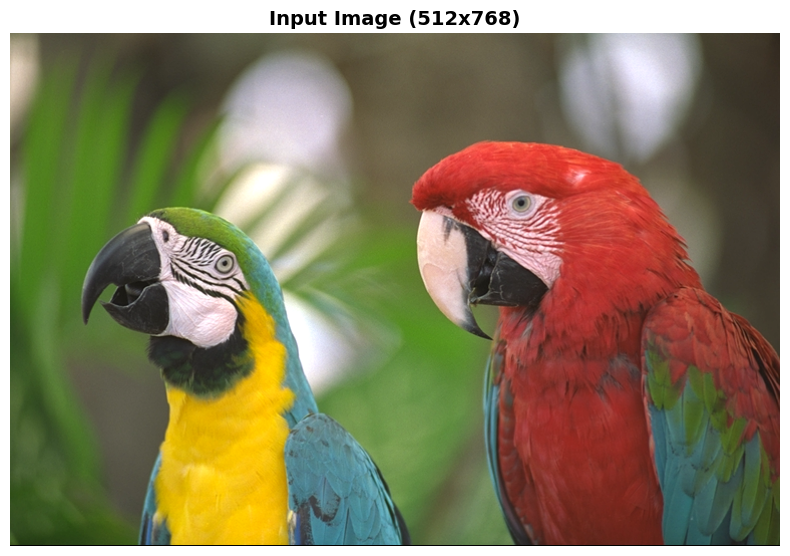

In [ ]:
# Display image
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f'Input Image ({image.shape[0]}x{image.shape[1]})', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f'⚠️ Could not display image: {exc}')


---

# 🗜️ Part 2: High-Level API - Compress & Decompress

Use the simple `compress()` and `decompress()` functions for end-to-end image compression.

This pipeline includes:
- **VAE Encoding**: Latent space compression (4×8×8 downsampling)
- **Hadamard Transform**: 4-channel decorrelation
- **Wavelet Decomposition**: Multi-scale frequency analysis
- **Quantization**: Lossy compression with quality parameter
- **ANS Entropy Coding**: Lossless bitstream compression


In [ ]:
print("🗜️ Compressing image...\n")

compressed = compress(
    image,
    model='sdxl-vae',
    quality=70,
    use_hadamard=True,
    # --- FIX: Pass config_path correctly ---
    config_path=str(config_path) if config_path.exists() else None,
)

original_bytes = image.nbytes
compressed_bytes = len(compressed)
ratio = get_compression_ratio(image, compressed)

print(f"✅ Compression complete!")
print(f"   Original size:    {original_bytes:,} bytes")
print(f"   Compressed size:  {compressed_bytes:,} bytes")
print(f"   Compression ratio: {ratio:.2f}x")
print(f"   Space saved:      {(1 - 1/ratio)*100:.1f}%")

info = get_compression_info(compressed)
print(f"\n📋 Metadata: {info}")

print(f"\n🔄 Decompressing...\n")
recon = decompress(
    compressed,
    # --- FIX: Pass config_path correctly ---
    config_path=str(config_path) if config_path.exists() else None,
)
print(f"✅ Decompression complete!")
print(f"   Shape: {recon.shape}, Dtype: {recon.dtype}")


🗜️ Compressing image...

✅ Compression complete!
   Original size:    1,179,648 bytes
   Compressed size:  99,434 bytes
   Compression ratio: 11.86x
   Space saved:      91.6%

📋 Metadata: {'model': 'sdxl-vae', 'wavelet_levels': 1, 'image_shape': [512, 768, 3], 'initial_state': 0}

🔄 Decompressing...

✅ Decompression complete!
   Shape: (512, 768, 3), Dtype: float32


📊 Quality Metrics:
   MSE:  0.125916
   PSNR: 9.00 dB


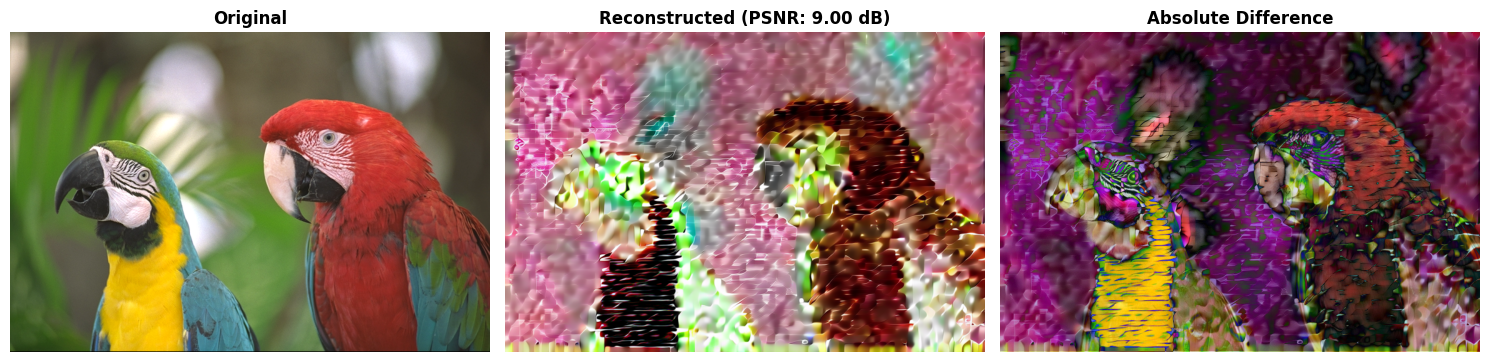

In [ ]:
# Calculate quality metrics
orig = image.astype(np.float32) / 255.0
mse = float(np.mean((orig - recon) ** 2))
psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

print("📊 Quality Metrics:")
print(f"   MSE:  {mse:.6f}")
print(f"   PSNR: {psnr:.2f} dB")

# Display comparison
try:
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(recon)
    axes[1].set_title(f'Reconstructed (PSNR: {psnr:.2f} dB)', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    diff = np.abs(orig - recon)
    axes[2].imshow(diff, cmap='hot', vmin=0, vmax=diff.max())
    axes[2].set_title('Absolute Difference', fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f'⚠️ Could not display comparison: {exc}')


---

# ⚙️ Part 3: Low-Level ECS Pipeline

Build compression pipelines explicitly using the Entity-Component-System architecture.

**Key Concepts:**
- **World**: Container for all entities and components
- **Entity**: Integer ID representing an image/compression job  
- **Components**: Data containers (RGB, Latent4, YUVW4, etc.)
- **Systems**: Transformations that operate on components
- **Arena**: Zero-copy memory allocator for efficient tensor storage


In [ ]:
print("⚙️ Building ECS pipeline...\n")

# Create world and spawn entity
world = World(arena_bytes=512 << 20)  # 512 MB arena
eid = world.spawn_image(image)
print(f"✅ Created entity {eid} with image shape {image.shape}")

# Create systems
config_str = str(config_path) if config_path.exists() else None
encoder = OnnxVAEEncode(model='sdxl-vae', config_path=config_str, mode='encode')
decoder = OnnxVAEDecode(model='sdxl-vae', config_path=config_str, mode='decode')

# Step 1: VAE Encode
print("\n📥 Step 1: VAE Encoding...")
encoder.run(world, [eid])
latent = world.get_component(eid, Latent4)
latent_view = world.arena.view(latent.z)
print(f"   ✅ Encoded to latent shape: {latent_view.shape}")
print(f"      Compression: {image.shape} → {latent_view.shape} (8x spatial reduction)")

# Step 2: Hadamard Transform
print("\n🔄 Step 2: Hadamard Transform (forward)...")
Hadamard4(mode='forward').run(world, [eid])
yuvw = world.get_component(eid, YUVW4)
yuvw_view = world.arena.view(yuvw.t)
print(f"   ✅ Transformed to YUVW4 shape: {yuvw_view.shape}")

# Step 3: Hadamard Inverse
print("\n🔄 Step 3: Hadamard Transform (inverse)...")
Hadamard4(mode='inverse').run(world, [eid])
print("   ✅ Reversed to Latent4")

# Step 4: VAE Decode
print("\n📤 Step 4: VAE Decoding...")
decoder.run(world, [eid])
recon_component = world.get_component(eid, ReconRGB)
recon_view = world.arena.view(recon_component.pix)
print(f"   ✅ Decoded to RGB shape: {recon_view.shape}")

print("\n✅ ECS pipeline complete!")


⚙️ Building ECS pipeline...

✅ Created entity 0 with image shape (512, 768, 3)

📥 Step 1: VAE Encoding...
   ✅ Encoded to latent shape: (4, 64, 96)
      Compression: (512, 768, 3) → (4, 64, 96) (8x spatial reduction)

🔄 Step 2: Hadamard Transform (forward)...
   ✅ Transformed to YUVW4 shape: (4, 64, 96)

🔄 Step 3: Hadamard Transform (inverse)...
   ✅ Reversed to Latent4

📤 Step 4: VAE Decoding...
   ✅ Decoded to RGB shape: (512, 768, 3)

✅ ECS pipeline complete!


---

# 🚀 Part 4: Batch Processing

Process multiple images efficiently in a single system run. The ECS architecture automatically groups entities with matching shapes for optimized batch processing.


In [ ]:
print("🚀 Batch processing demonstration\n")

# Create world and multiple images
world = World(arena_bytes=512 << 20)
num_images = 4
images = [
    np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)
    for _ in range(num_images)
]

# Spawn all entities at once
eids = world.spawn_batch_images(images)
print(f"✅ Created {len(eids)} entities: {eids}")

# Create systems
config_str = str(config_path) if config_path.exists() else None
encoder = OnnxVAEEncode(model='sdxl-vae', config_path=config_str, mode='encode')
decoder = OnnxVAEDecode(model='sdxl-vae', config_path=config_str, mode='decode')

# Encode all images in one batch
print(f"\n📥 Encoding {num_images} images in batch...")
encoder.run(world, eids)
print("   ✅ Batch encoding complete")

# Decode all images in one batch
print(f"\n📤 Decoding {num_images} images in batch...")
decoder.run(world, eids)
print("   ✅ Batch decoding complete")

# Verify results
print(f"\n📊 Results:")
for i, eid in enumerate(eids):
    recon = world.get_component(eid, ReconRGB)
    recon_view = world.arena.view(recon.pix)
    latent = world.get_component(eid, Latent4)
    latent_view = world.arena.view(latent.z)
    print(f"   Entity {eid}: {images[i].shape} → latent {latent_view.shape} → recon {recon_view.shape}")

print(f"\n✅ Processed {num_images} images efficiently with batch operations!")


🚀 Batch processing demonstration

✅ Created 4 entities: [0, 1, 2, 3]

📥 Encoding 4 images in batch...
   ✅ Batch encoding complete

📤 Decoding 4 images in batch...
   ✅ Batch decoding complete

📊 Results:
   Entity 0: (256, 256, 3) → latent (4, 32, 32) → recon (256, 256, 3)
   Entity 1: (256, 256, 3) → latent (4, 32, 32) → recon (256, 256, 3)
   Entity 2: (256, 256, 3) → latent (4, 32, 32) → recon (256, 256, 3)
   Entity 3: (256, 256, 3) → latent (4, 32, 32) → recon (256, 256, 3)

✅ Processed 4 images efficiently with batch operations!


---

# 🎯 Part 5: Fluent Pipeline API

The fluent API provides an elegant way to build compression pipelines using method chaining.

In [ ]:
from vaerans_ecs.systems.wavelet import WaveletCDF53
from vaerans_ecs.systems.quantize import QuantizeU8
from vaerans_ecs.systems.ans import ANSEncode, ANSDecode
from vaerans_ecs.components.entropy import ANSBitstream

print("🎯 Fluent Pipeline API Example\n")

# Create world and entity
world = World(arena_bytes=512 << 20)
eid = world.spawn_image(image)

config_str = str(config_path) if config_path.exists() else None

# Calculate safe wavelet levels
latent_comp = world.pipe(eid).to(OnnxVAEEncode(model='sdxl-vae', config_path=config_str, mode='encode')).out(Latent4)
latent_arr = world.arena.view(latent_comp.z)
_, h, w = latent_arr.shape
safe_levels = max(1, int(np.log2(min(h, w) // 8)))
safe_levels = min(safe_levels, 4)

print(f"✅ Latent shape: {latent_arr.shape}")
print(f"   Using {safe_levels} wavelet decomposition levels\n")

# Method 1: Method chaining with .to()
print("📝 Method 1: Chaining with .to()\n")
print("bitstream = (")
print("    world.pipe(eid)")
print("         .to(Hadamard4(mode='forward'))")
print(f"         .to(WaveletCDF53(levels={safe_levels}, mode='forward'))")
print("         .to(QuantizeU8(quality=70, mode='forward'))")
print("         .to(ANSEncode())")
print("         .out(ANSBitstream)")
print(")\n")

bitstream = (
    world.pipe(eid)
         .to(Hadamard4(mode='forward'))
         .to(WaveletCDF53(levels=safe_levels, mode='forward'))
         .to(QuantizeU8(quality=70, per_band=True, mode='forward'))
         .to(ANSEncode())
         .out(ANSBitstream)
)

bitstream_data = world.arena.view(bitstream.data)
print(f"✅ Compressed to {len(bitstream_data)} bytes\n")

# Method 2: Decompression with .select()
print("📝 Method 2: Decompression with .select()\n")
print("recon = (")
print("    world.pipe(eid)")
print("         .select(ANSBitstream)  # Start from compressed data")
print("         .to(ANSDecode())")
print("         .to(QuantizeU8(quality=70, mode='inverse'))")
print(f"         .to(WaveletCDF53(levels={safe_levels}, mode='inverse'))")
print("         .to(Hadamard4(mode='inverse'))")
print("         .to(OnnxVAEDecode(model='sdxl-vae'))")
print("         .out(ReconRGB)")
print(")\n")

recon = (
    world.pipe(eid)
         .select(ANSBitstream)
         .to(ANSDecode())
         .to(QuantizeU8(quality=70, per_band=True, mode='inverse'))
         .to(WaveletCDF53(levels=safe_levels, mode='inverse'))
         .to(Hadamard4(mode='inverse'))
         .to(OnnxVAEDecode(model='sdxl-vae', config_path=config_str, mode='decode'))
         .out(ReconRGB)
)

recon_arr = world.arena.view(recon.pix)
print(f"✅ Decompressed to shape {recon_arr.shape}")
print(f"\n🎉 Fluent API provides elegant, readable pipeline construction!")

🎯 Fluent Pipeline API Example

✅ Latent shape: (4, 64, 96)
   Using 3 wavelet decomposition levels

📝 Method 1: Chaining with .to()

bitstream = (
    world.pipe(eid)
         .to(Hadamard4(mode='forward'))
         .to(WaveletCDF53(levels=3, mode='forward'))
         .to(QuantizeU8(quality=70, mode='forward'))
         .to(ANSEncode())
         .out(ANSBitstream)
)

✅ Compressed to 15656 bytes

📝 Method 2: Decompression with .select()

recon = (
    world.pipe(eid)
         .select(ANSBitstream)  # Start from compressed data
         .to(ANSDecode())
         .to(QuantizeU8(quality=70, mode='inverse'))
         .to(WaveletCDF53(levels=3, mode='inverse'))
         .to(Hadamard4(mode='inverse'))
         .to(OnnxVAEDecode(model='sdxl-vae'))
         .out(ReconRGB)
)

✅ Decompressed to shape (512, 768, 3)

🎉 Fluent API provides elegant, readable pipeline construction!


---

# 🎉 Congratulations!

You've successfully explored the VAE+ANS Image Compression SDK!

## 📚 What You Learned

1. **✅ High-Level API**: Simple `compress()` and `decompress()` functions
2. **✅ ECS Architecture**: Entity-Component-System pattern with zero-copy memory
3. **✅ Batch Processing**: Efficient multi-image processing
4. **✅ Fluent Pipelines**: Elegant method chaining with `.to()` and `.select()`

## 🚀 Next Steps

### Explore More Examples
Check out the `examples/` directory for advanced usage:
- `fluent_api_complete.py` - Complete fluent API demonstrations
- `full_pipeline_example.py` - End-to-end compression with all stages
- `metrics_example.py` - Quality evaluation and rate-distortion curves
- `batch_pipeline.py` - Batch processing patterns
- `pipeline_example.py` - Custom pipeline construction

### Run Examples Locally
```bash
# Basic compression
python examples/quickstart_api.py --input path/to/image.png --quality 80

# Full pipeline with metrics
python examples/full_pipeline_example.py --input image.png --output recon.png

# Fluent API demo
python examples/fluent_api_complete.py --size 512 --quality 70
```

### Documentation
- `SOFTWARE_DESIGN.md` - Complete architecture specification
- `IMPLEMENTATION_STATUS.md` - Implementation progress
- `DX_COMPARISON.md` - API design comparisons
- `README.md` - Project overview

## 🔗 Resources

- **Repository**: [GitHub](https://github.com/YOUR_USERNAME/vaerans_ecs_design_artifact)
- **Issues**: [Report bugs or request features](https://github.com/YOUR_USERNAME/vaerans_ecs_design_artifact/issues)
- **Design Docs**: Comprehensive architecture in `SOFTWARE_DESIGN.md`

## 💡 Key Features

- 🏗️ **ECS Architecture**: Modular, extensible, testable
- 🚀 **Zero-Copy Memory**: Efficient Arena allocator
- 🔄 **Fluent API**: Readable pipeline construction
- 📦 **Batch-First**: Optimized multi-image processing
- 🎯 **Type-Safe**: Full IDE support with type hints
- 🧪 **Well-Tested**: Comprehensive test coverage

---

*Built with ❤️ using Entity-Component-System architecture*